# Assignment 1: Classifying handwritten digits using probability theory

# 1. Introduce the problem in your own words. You should mention what data we use, what we want to do with it and how we will do it. Explain with your own words the Naive Bayes classifier, it's assumptions and how this can classify the digits $0-9$.

Image recognition is a big thing in machine learning. This small interactive paper will describe and show, an implementation of the Naive Bayes classifier algorithm in an attempt to classify handwritten numbers. Using a database of handwritten numbers between 0 and 9, first we analyze and train on a subset, then evaluate our result on a different subset, these are respectively the training set and the test set.


NOTER:
what we are doing: Predicting the number written in image using the naive Bayes classifier. 
How: Using a big data set, we set out some learning samples and  some test samples, the model is trained on the training set and model performance was evaluated on the test set.
How: 

In [1]:
from __future__ import division
import numpy as np
import pylab as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.metrics import plot_confusion_matrix


# 2. Load the data

In [2]:
# load data
data = np.load("mnist_bin.npz") # insert your answer here

# get vector representation of binary digits
X = data['X']

# get binary labels
y = data['y']

print('The shape of X is (%d, %d)' % X.shape)
print('The shape of y is (%d)\n' % y.shape)

# Dimensions
N, D = X.shape

print('Number of images: %d' % N)
print('Number of pixels: %d' % D)


The shape of X is (70000, 784)
The shape of y is (70000)

Number of images: 70000
Number of pixels: 784


#### Run the code beneath. It plots 10 images of each digit. 


In [3]:
def show_image(x, title="", clim=None, cmap=plt.cm.gray, colorbar=False):
    ax = plt.gca()
    im = ax.imshow(x.reshape((28, 28)), cmap=cmap, clim=clim)
    
    if len(title) > 0:
        plt.title(title)
        
    plt.axis('off')
    
    if colorbar:
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        plt.colorbar(im, cax=cax)

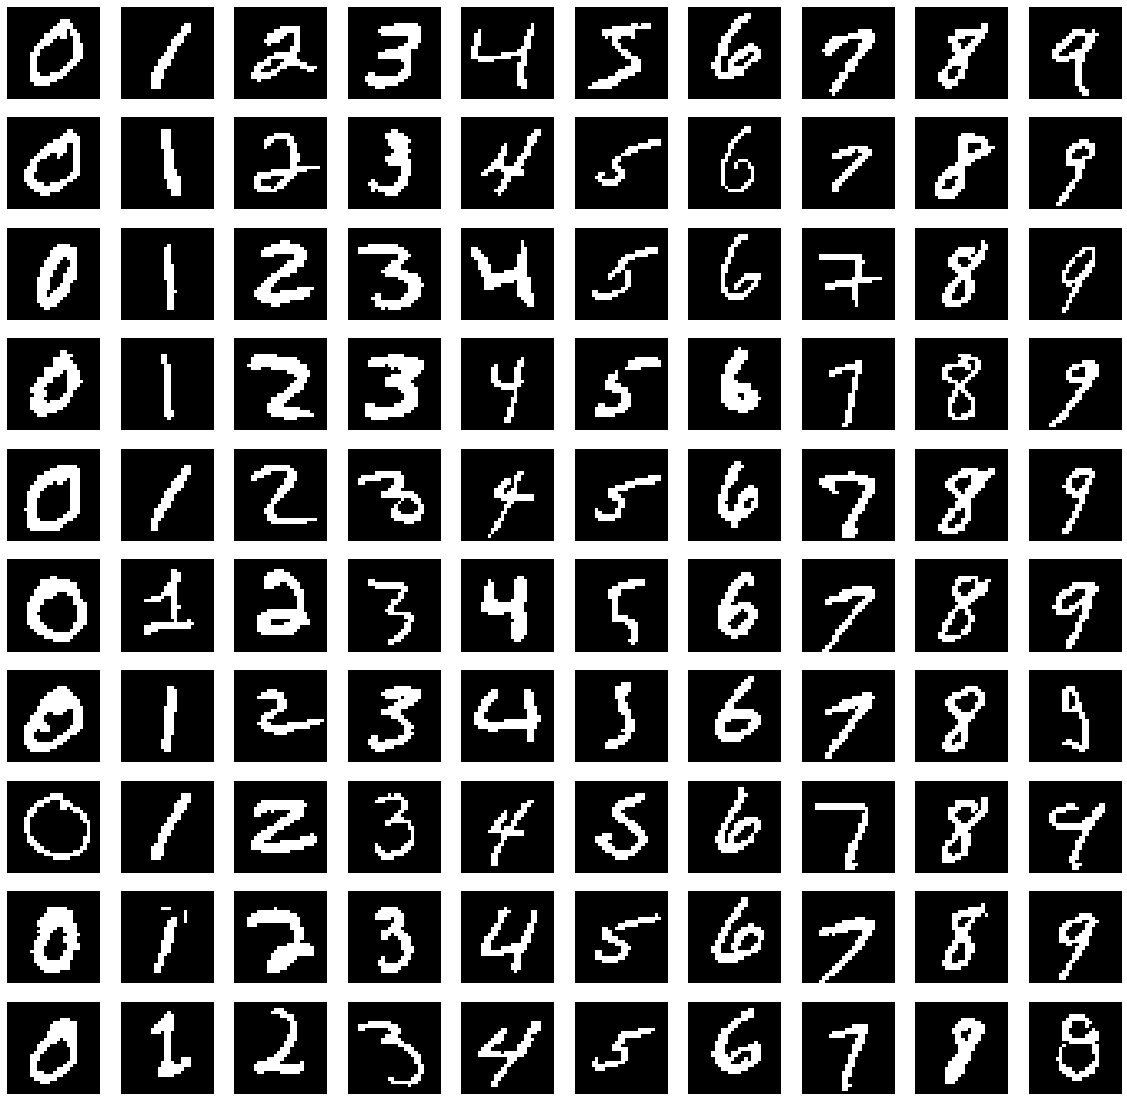

In [4]:
num_images_per_row  = 10
num_labels          = 10

plt.figure(figsize=(20, 20))
counter             = 1
for i in range(num_labels):
    for l in range(num_images_per_row):
        plt.subplot(num_labels, num_images_per_row, counter)

        all_images_belonging_to_class_l = X[y==l,:]
        one_images_belonging_to_class_l = all_images_belonging_to_class_l[i]
        
        show_image(one_images_belonging_to_class_l)  
        counter += 1


# 3. Explain what a training set is, what a test set is and why we as data scientists *always* split data into test/train before doing any modelling. What do we want to avoid?

A training set is the data points we use to train our model. The test set is data that the model hasn't been trained on but is used to evaluate model performance. 
We do this to avoid overfitting the model such that it fails to generalize to real world data.

In [5]:
N = len(X)
N_train = int(0.8*N)
N_test = N - N_train

# set random seed:
np.random.seed(0) # don't change this :-)

# create a random permutation for splitting into training and test
randperm = np.random.permutation(N)

# split into training and test
train_idx = randperm[:N_train]
test_idx = randperm[N_train:]
Xtrain, Xtest = X[train_idx, :], X[test_idx, :]
ytrain, ytest = y[train_idx], y[test_idx]

print('Total number of images:\t\t%d' % N)
print('Number of training images:\t%d' % N_train)
print('Number of test images:\t\t%d' % N_test)

Total number of images:		70000
Number of training images:	56000
Number of test images:		14000


# 4. Implement/change the code to handle all digits. 
### Fitting the Naı̈ve-Bayes model to training set: the prior

The code beneath is taken from Exercise 1 and it only handles digits 0 and 1. Change the code to handle all digits.

In [6]:
counts = []
for i in range(10):
    count = np.sum(ytrain == i)
    counts.append(count)

counts = np.array(counts) 


# compute prior prob.: P(Y=0) = count_zeros/N_train and P(Y=1) = count_ones/N_train

# let's store both probabilities in a vector
prior = counts / N_train

print('Number of training digits:%d' % N_train)
for i in range(10):
    print(f"Number of {i}s: {counts[i]}")
print()

for i in range(10):
    print("Prior probability of seeing a {}:\tp(y = {}) = {}/{} = {:.2f}".format(i,i,counts[i],N_train,prior[i]))

Number of training digits:56000
Number of 0s: 5573
Number of 1s: 6280
Number of 2s: 5592
Number of 3s: 5700
Number of 4s: 5480
Number of 5s: 5063
Number of 6s: 5507
Number of 7s: 5778
Number of 8s: 5449
Number of 9s: 5578

Prior probability of seeing a 0:	p(y = 0) = 5573/56000 = 0.10
Prior probability of seeing a 1:	p(y = 1) = 6280/56000 = 0.11
Prior probability of seeing a 2:	p(y = 2) = 5592/56000 = 0.10
Prior probability of seeing a 3:	p(y = 3) = 5700/56000 = 0.10
Prior probability of seeing a 4:	p(y = 4) = 5480/56000 = 0.10
Prior probability of seeing a 5:	p(y = 5) = 5063/56000 = 0.09
Prior probability of seeing a 6:	p(y = 6) = 5507/56000 = 0.10
Prior probability of seeing a 7:	p(y = 7) = 5778/56000 = 0.10
Prior probability of seeing a 8:	p(y = 8) = 5449/56000 = 0.10
Prior probability of seeing a 9:	p(y = 9) = 5578/56000 = 0.10


### Fitting the Naı̈ve-Bayes model to training set: the likelihood

In [7]:
Xtrain_numbers = []
for i in range(10):
    Xtrain_numbers.append(Xtrain[ytrain == i, :])

# fit models
p_numbers = []
for i in range(10):
    p_numbers.append(np.mean(Xtrain_numbers[i],axis=0))

In [8]:
# This code should be sufficient, i.e. don't change this.
def log_likelihood(x_new, p_digit):
    pixel_log_lik = x_new*np.log(p_digit + 1e-16) + (1-x_new)*np.log(1-p_digit)
    return np.sum(pixel_log_lik)
    
image_idxs_to_be_classified = [0,10,510,810]
for image_idx in image_idxs_to_be_classified:
    x_new = Xtrain[image_idx]
    print('Image idx: %d (label=%d)' % (image_idx, ytrain[image_idx]))
    
    for i in range(10):
        print('p(x_new | Y=%d): %3.2e' % (i ,np.exp(log_likelihood(x_new, p_numbers[i]))))
    print('\n')

Image idx: 0 (label=0)
p(x_new | Y=0): 1.17e-85
p(x_new | Y=1): 1.53e-243
p(x_new | Y=2): 3.91e-119
p(x_new | Y=3): 5.44e-123
p(x_new | Y=4): 1.82e-118
p(x_new | Y=5): 3.26e-109
p(x_new | Y=6): 6.55e-99
p(x_new | Y=7): 6.98e-188
p(x_new | Y=8): 1.24e-109
p(x_new | Y=9): 1.08e-134


Image idx: 10 (label=1)
p(x_new | Y=0): 3.40e-122
p(x_new | Y=1): 2.94e-34
p(x_new | Y=2): 5.53e-75
p(x_new | Y=3): 1.24e-76
p(x_new | Y=4): 2.29e-86
p(x_new | Y=5): 2.74e-76
p(x_new | Y=6): 1.37e-112
p(x_new | Y=7): 1.06e-83
p(x_new | Y=8): 7.47e-68
p(x_new | Y=9): 6.80e-81


Image idx: 510 (label=1)
p(x_new | Y=0): 2.39e-125
p(x_new | Y=1): 5.00e-34
p(x_new | Y=2): 3.51e-73
p(x_new | Y=3): 1.31e-78
p(x_new | Y=4): 7.04e-96
p(x_new | Y=5): 9.44e-78
p(x_new | Y=6): 3.88e-88
p(x_new | Y=7): 3.38e-107
p(x_new | Y=8): 7.98e-68
p(x_new | Y=9): 6.62e-90


Image idx: 810 (label=6)
p(x_new | Y=0): 6.20e-151
p(x_new | Y=1): 7.56e-150
p(x_new | Y=2): 1.27e-89
p(x_new | Y=3): 2.06e-128
p(x_new | Y=4): 4.94e-108
p(x_ne

### Implementing Bayes's theorem

In [9]:
def compute_posterior_prob(x_new):
    log_lik_numbers = []
    for i in range(10):
        log_lik_numbers.append(log_likelihood(x_new, p_numbers[i]))
        

    # exponentiate
    lik_numbers = []
    for i in range(10):
        lik_numbers.append(np.exp(log_lik_numbers[i]))
    # extend code here

#     # implement eq. (4)
    term_numbers = []
    for i in range(10):
        term_numbers.append(lik_numbers[i]*prior[i])
    evidence = np.sum(term_numbers)
    
    post_prob_numbers = []
    for i in range(10):
        post_prob_numbers.append(term_numbers[i]/evidence)

    posterior = np.array(post_prob_numbers)
    return posterior


### A simple classification rule: take the class with largest posterior probability

In [10]:
def classify(x):
    posterior = compute_posterior_prob(x)
    predicted_label = np.argmax(posterior)
    return predicted_label
    

### Change this code to classify some of the images 

p(Y|x) = (1.0)
True label: 2
Predicted label: 6
p(Y|x) = (1.0)
True label: 7
Predicted label: 9
p(Y|x) = (1.0)
True label: 7
Predicted label: 7
p(Y|x) = (1.0)
True label: 3
Predicted label: 3
p(Y|x) = (1.0)
True label: 1
Predicted label: 1
p(Y|x) = (1.0)
True label: 3
Predicted label: 3
p(Y|x) = (1.0)
True label: 1
Predicted label: 1
p(Y|x) = (1.0)
True label: 7
Predicted label: 7
p(Y|x) = (1.0)
True label: 3
Predicted label: 3
p(Y|x) = (0.7)
True label: 7
Predicted label: 8


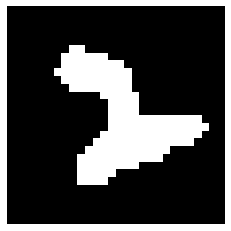

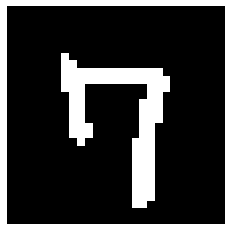

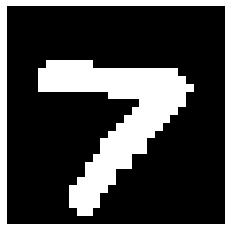

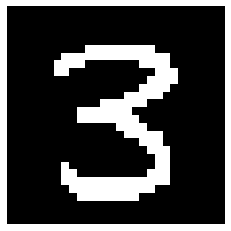

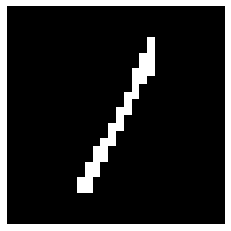

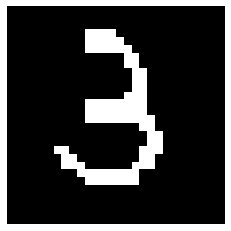

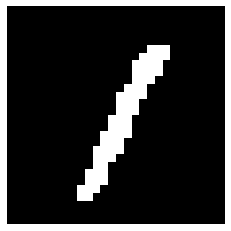

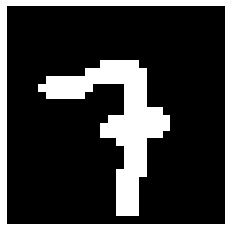

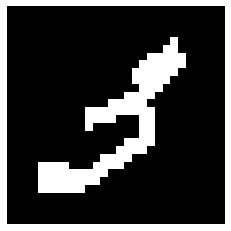

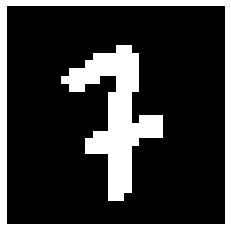

In [11]:
# Classifies the first 10 images in the test set
for i in range(10):
    f = plt.figure()
    
    # compute posterior probabilities
    posterior = compute_posterior_prob(Xtest[i, :])
    
    # get true label and predicted label
    true_label = ytest[i]
    predicted_label = classify(Xtest[i, :])
    
    # show image 
    show_image(Xtest[i, :])
    
    # Print result
    print('p(Y|x) = (%2.1f)' % np.max(posterior))
    print("True label:",true_label)
    print("Predicted label:",predicted_label)
    


### Let's compute the training and test errors

In [12]:
ytrain_hat = np.array([classify(x) for x in Xtrain])
ytest_hat = np.array([classify(x) for x in Xtest])

In [13]:
mean_train_acc = np.mean(ytrain_hat == ytrain)
mean_test_acc = np.mean(ytest_hat == ytest)
print('Training accuracy:\t%4.3f' % mean_train_acc)
print('Test accuracy:\t\t%4.3f' % mean_test_acc)

Training accuracy:	0.840
Test accuracy:		0.840


# 5. Compute the confusion matrix and explain what it shows.

C:\Users\KrisK\.conda\envs\pv36\lib\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


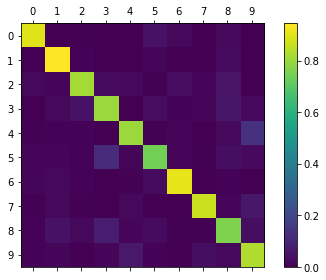

In [14]:
from sklearn.metrics import confusion_matrix
labels = list(range(10))
pred = np.array([classify(x) for x in Xtest])
cm = confusion_matrix(ytest, pred, labels,normalize="true")
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
fig.colorbar(cax)
ax.set_xticks(labels)
ax.set_yticks(labels)
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)
plt.tight_layout()
plt.show()

The confusion matrix shows the accuracy of the model on the test set on the different classes.
The vertical axis shows the actual labels of the test data while the horizontal axis shows the model prediction.
Each square is thus a label/prediction pair. Therefore, the squares in the diagonal shows the percentage of cases where the model correctly predicted the label. The more yellow a square is, the more often the label/prediction pair occured.
We can see that the model performance is quite good since the diagonal has a mostly bright yellow color. 
An outlier is the label 5 where the model quite often predicts 3 instead.
Another one is the label 4 which is often predicted as 9 (roughly 20%).

# 6. Error analysis: find images that are misclassified by the system.  Are there common characteristics among the images that are misclassified?

Some common characteristics among the images that are misclassified. Unfinished numbers, squeezed numbers in either x- or y-axis, numbers that in general look a bit like each other (4 and 9, 5 and 8) and numbers written with artifacts or other "errors".

A general thing that could cause these errors are the fact that the Naive Bayes classifier works on the assumption that all features contribute independently to the probability.

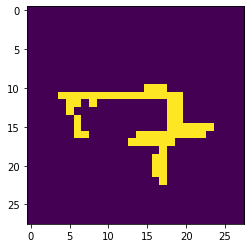

Prediction: 4
Actual: 7


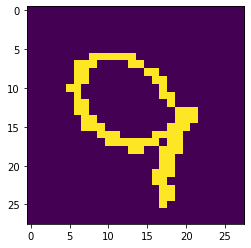

Prediction: 4
Actual: 9


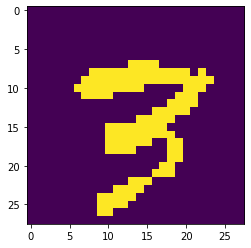

Prediction: 7
Actual: 3


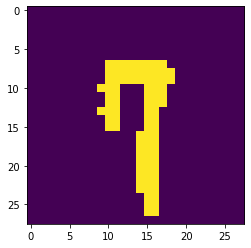

Prediction: 9
Actual: 7


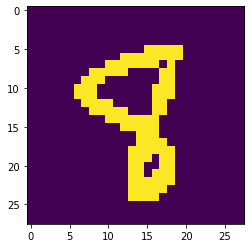

Prediction: 9
Actual: 8


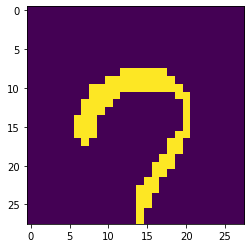

Prediction: 9
Actual: 7


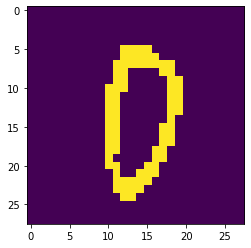

Prediction: 8
Actual: 0


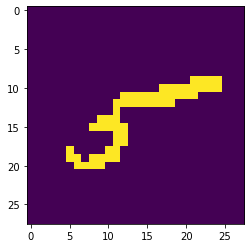

Prediction: 8
Actual: 5


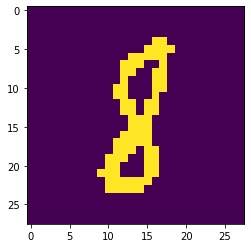

Prediction: 1
Actual: 8


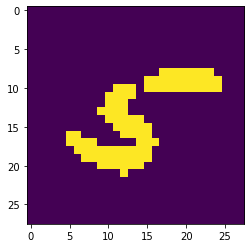

Prediction: 8
Actual: 5


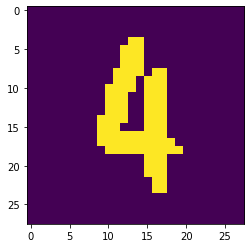

Prediction: 9
Actual: 4


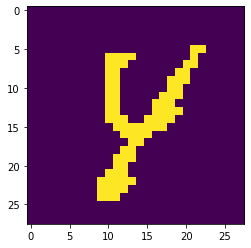

Prediction: 8
Actual: 4


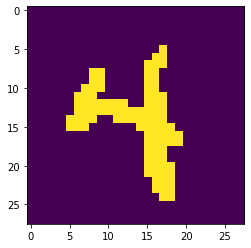

Prediction: 9
Actual: 4


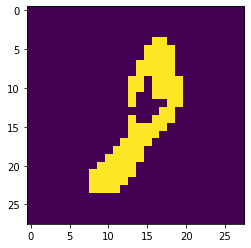

Prediction: 1
Actual: 8


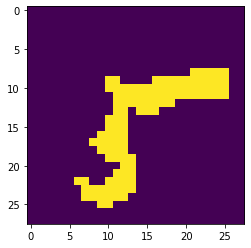

Prediction: 8
Actual: 5


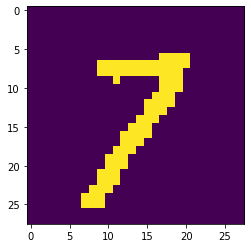

Prediction: 8
Actual: 7


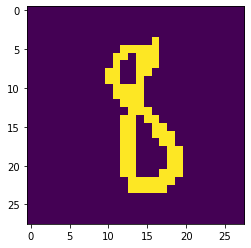

Prediction: 5
Actual: 8


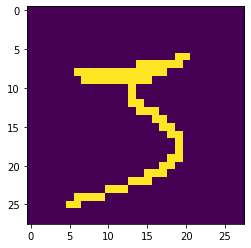

Prediction: 7
Actual: 3


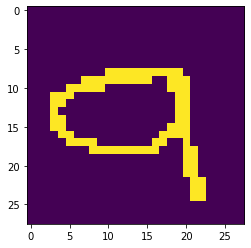

Prediction: 4
Actual: 9


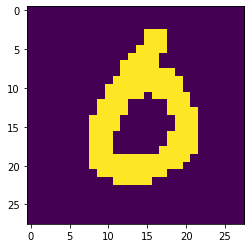

Prediction: 6
Actual: 0


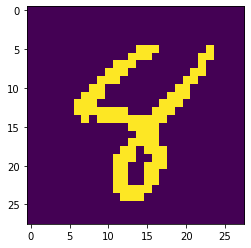

Prediction: 4
Actual: 8


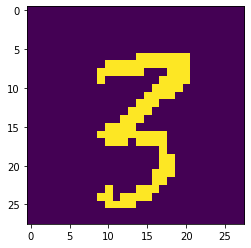

Prediction: 9
Actual: 3


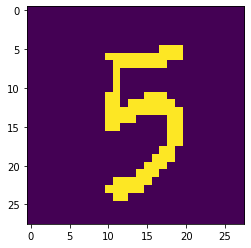

Prediction: 3
Actual: 5


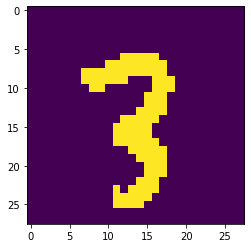

Prediction: 9
Actual: 3


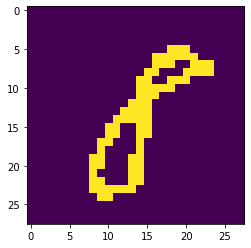

Prediction: 1
Actual: 8


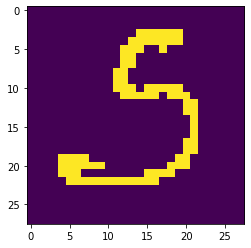

Prediction: 3
Actual: 5


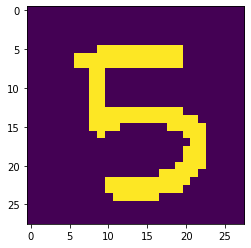

Prediction: 3
Actual: 5


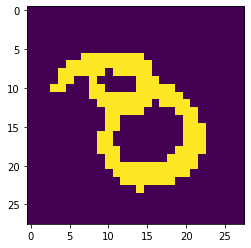

Prediction: 3
Actual: 8


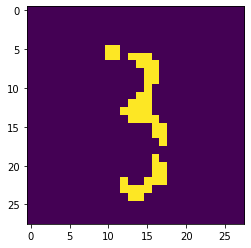

Prediction: 1
Actual: 3


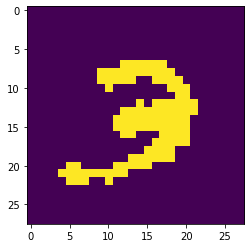

Prediction: 2
Actual: 3


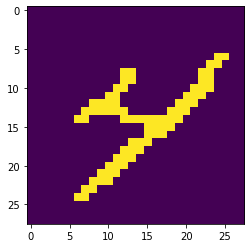

Prediction: 5
Actual: 4


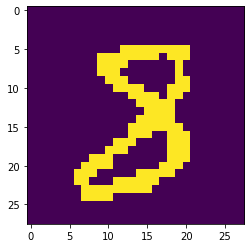

Prediction: 3
Actual: 8


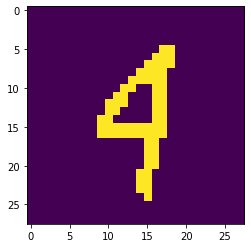

Prediction: 9
Actual: 4


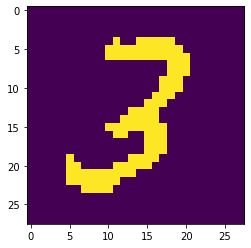

Prediction: 2
Actual: 3


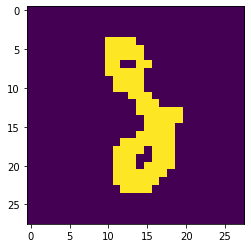

Prediction: 6
Actual: 8


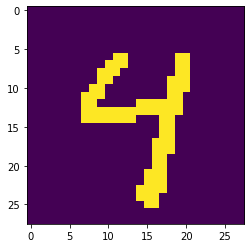

Prediction: 9
Actual: 4


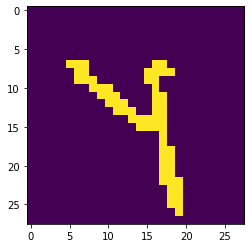

Prediction: 9
Actual: 4


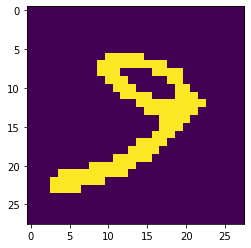

Prediction: 2
Actual: 9


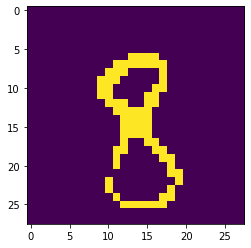

Prediction: 9
Actual: 8


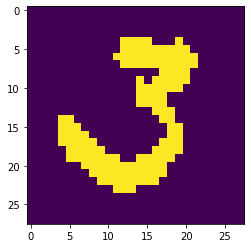

Prediction: 0
Actual: 3


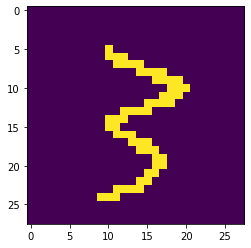

Prediction: 9
Actual: 3


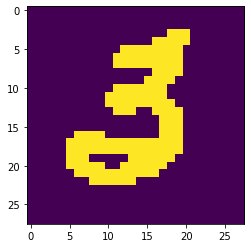

Prediction: 2
Actual: 3


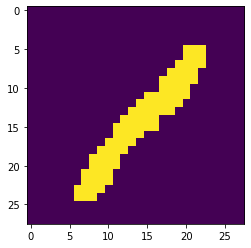

Prediction: 8
Actual: 1


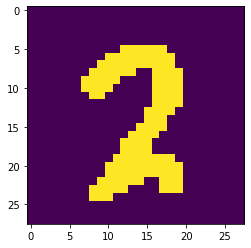

Prediction: 8
Actual: 2


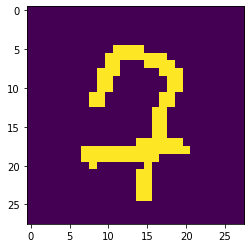

Prediction: 2
Actual: 7


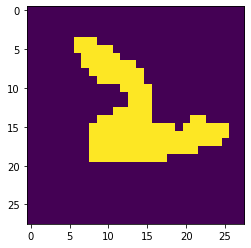

Prediction: 6
Actual: 2


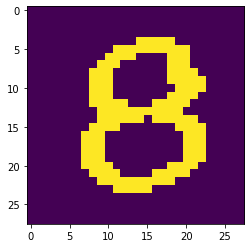

Prediction: 0
Actual: 8


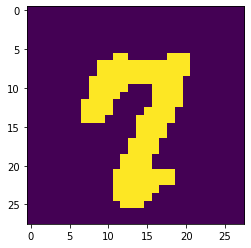

Prediction: 9
Actual: 7


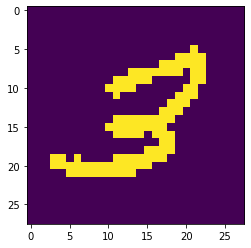

Prediction: 2
Actual: 3


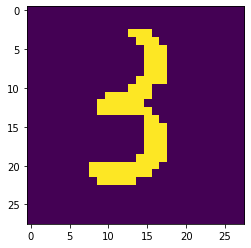

Prediction: 5
Actual: 3


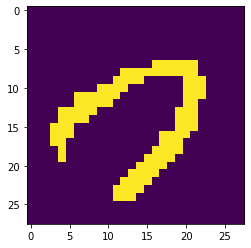

Prediction: 0
Actual: 7


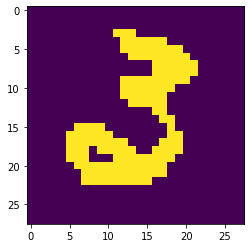

Prediction: 2
Actual: 3


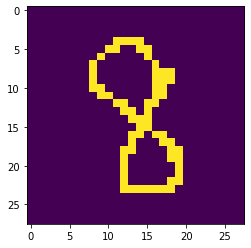

Prediction: 3
Actual: 8


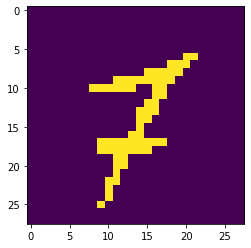

Prediction: 1
Actual: 7


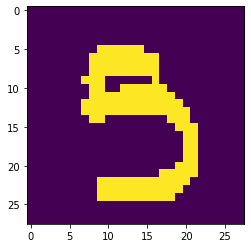

Prediction: 3
Actual: 5


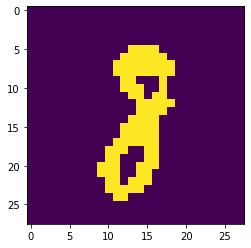

Prediction: 1
Actual: 8


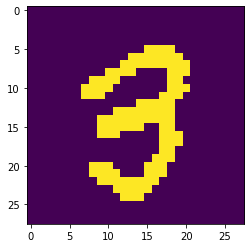

Prediction: 8
Actual: 3


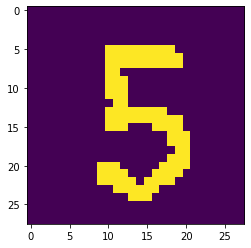

Prediction: 3
Actual: 5


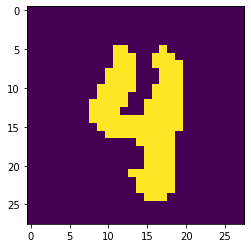

Prediction: 9
Actual: 4


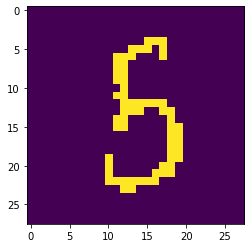

Prediction: 3
Actual: 5


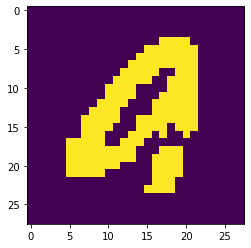

Prediction: 0
Actual: 9


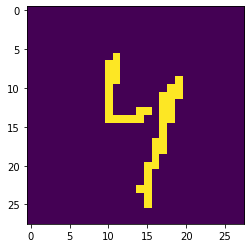

Prediction: 9
Actual: 4


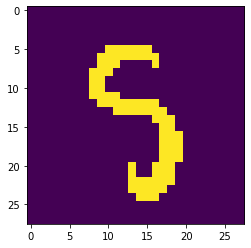

Prediction: 3
Actual: 5


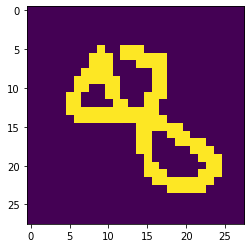

Prediction: 5
Actual: 8


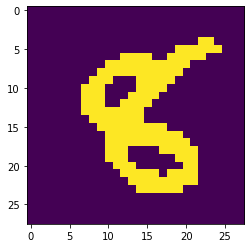

Prediction: 5
Actual: 8


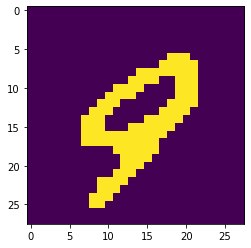

Prediction: 4
Actual: 9


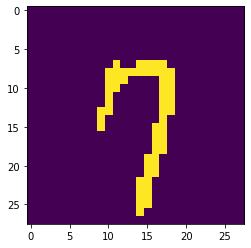

Prediction: 9
Actual: 7


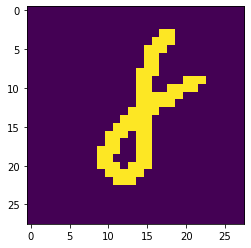

Prediction: 1
Actual: 8


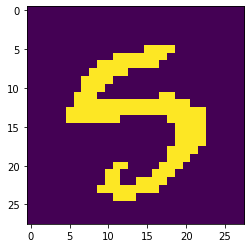

Prediction: 0
Actual: 5


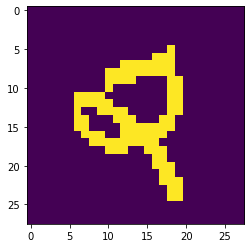

Prediction: 9
Actual: 2


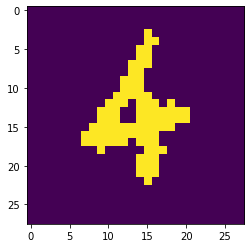

Prediction: 6
Actual: 4


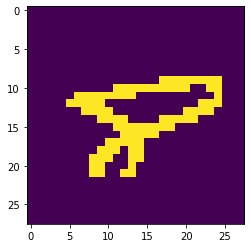

Prediction: 4
Actual: 8


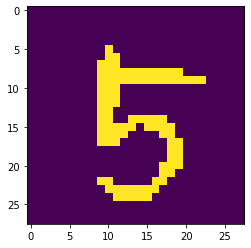

Prediction: 9
Actual: 5


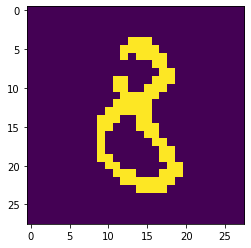

Prediction: 3
Actual: 8


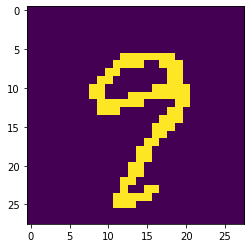

Prediction: 7
Actual: 9


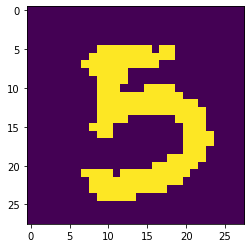

Prediction: 3
Actual: 5


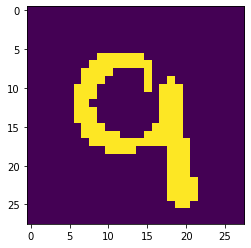

Prediction: 4
Actual: 9


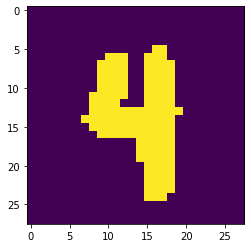

Prediction: 9
Actual: 4


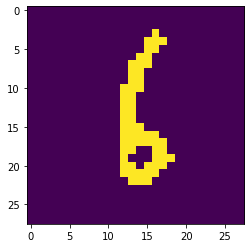

Prediction: 1
Actual: 6


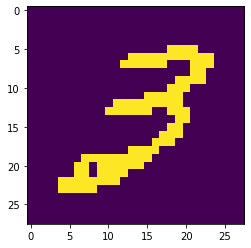

Prediction: 5
Actual: 3


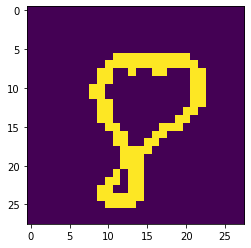

Prediction: 9
Actual: 8


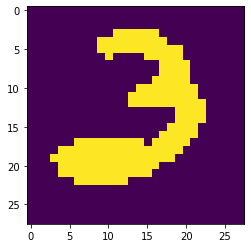

Prediction: 2
Actual: 3


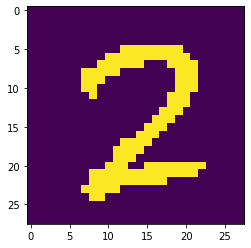

Prediction: 8
Actual: 2


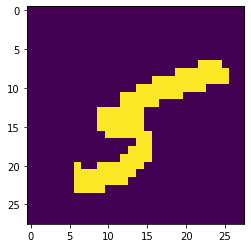

Prediction: 8
Actual: 5


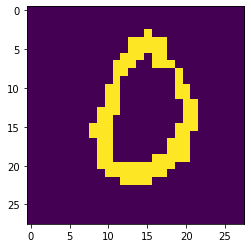

Prediction: 6
Actual: 0


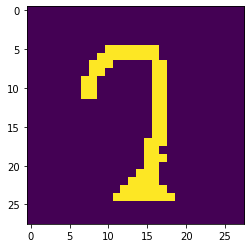

Prediction: 3
Actual: 2


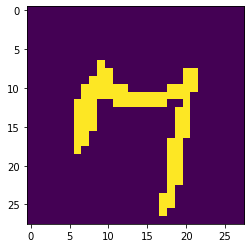

Prediction: 4
Actual: 7


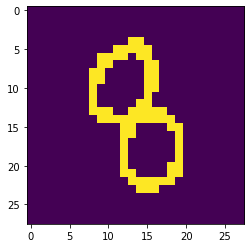

Prediction: 3
Actual: 8


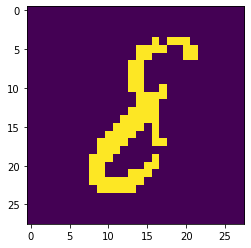

Prediction: 1
Actual: 8


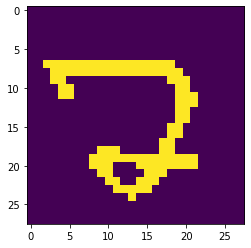

Prediction: 7
Actual: 2


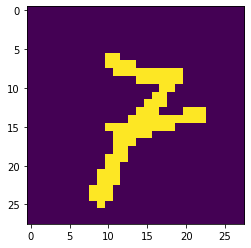

Prediction: 8
Actual: 7


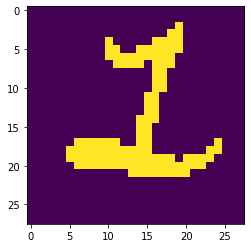

Prediction: 2
Actual: 1


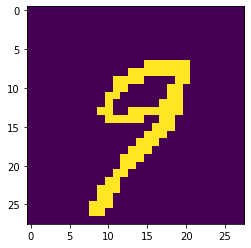

Prediction: 7
Actual: 9


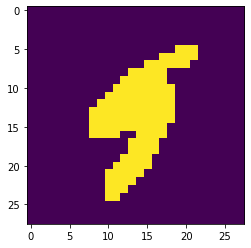

Prediction: 8
Actual: 9


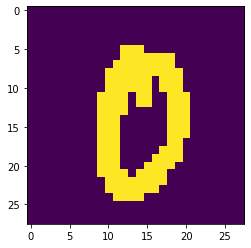

Prediction: 8
Actual: 0


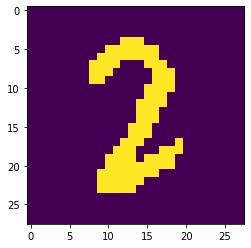

Prediction: 3
Actual: 2


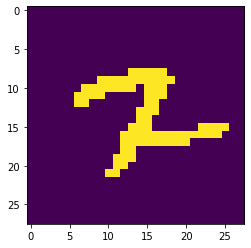

Prediction: 7
Actual: 2


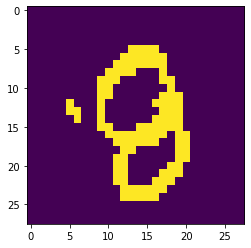

Prediction: 9
Actual: 8


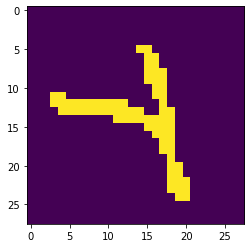

Prediction: 9
Actual: 4


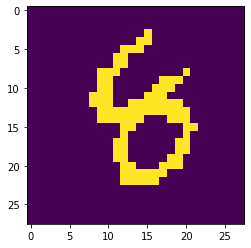

Prediction: 6
Actual: 8


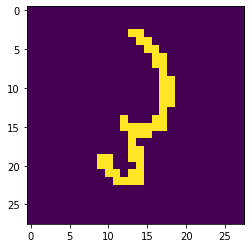

Prediction: 1
Actual: 3


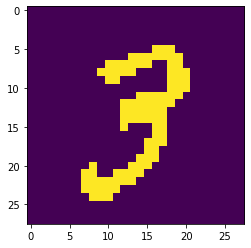

Prediction: 8
Actual: 3


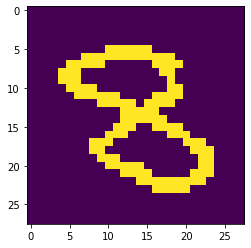

Prediction: 2
Actual: 8


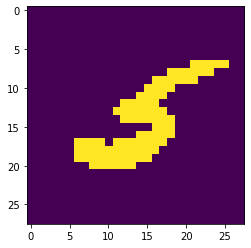

Prediction: 2
Actual: 5


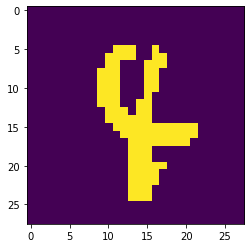

Prediction: 5
Actual: 4


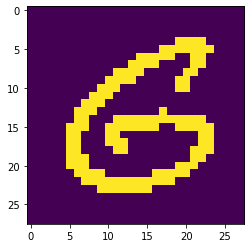

Prediction: 5
Actual: 6


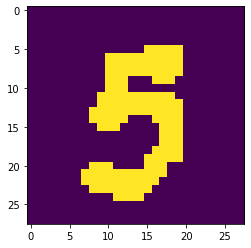

Prediction: 3
Actual: 5


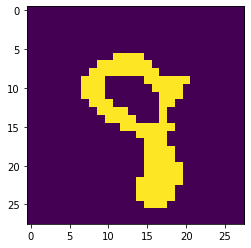

Prediction: 9
Actual: 8


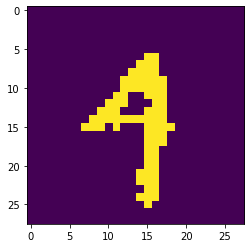

Prediction: 9
Actual: 4


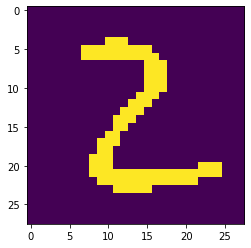

Prediction: 3
Actual: 2


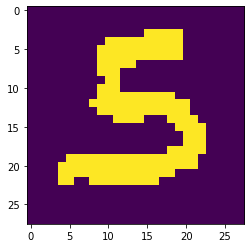

Prediction: 3
Actual: 5


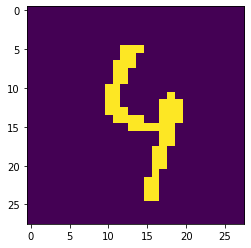

Prediction: 9
Actual: 4


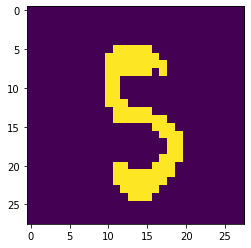

Prediction: 3
Actual: 5


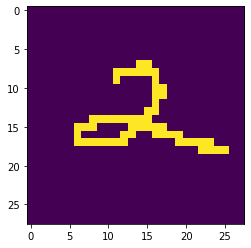

Prediction: 4
Actual: 2


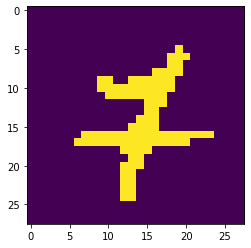

Prediction: 4
Actual: 7


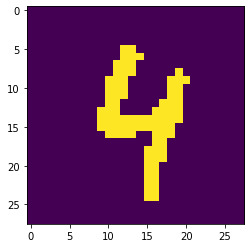

Prediction: 9
Actual: 4


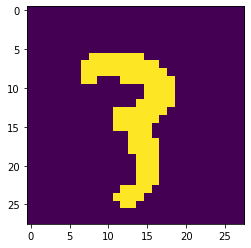

Prediction: 9
Actual: 3


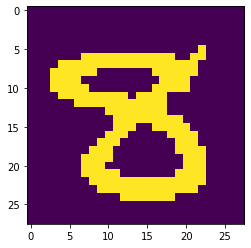

Prediction: 3
Actual: 8


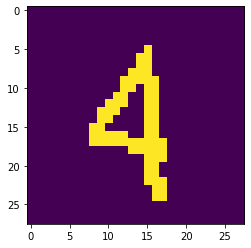

Prediction: 9
Actual: 4


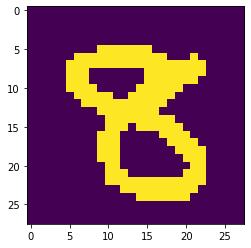

Prediction: 3
Actual: 8


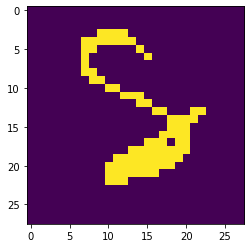

Prediction: 6
Actual: 8


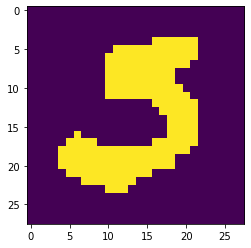

Prediction: 0
Actual: 5


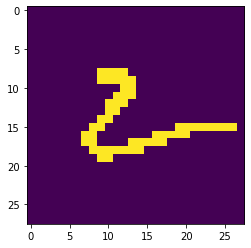

Prediction: 6
Actual: 2


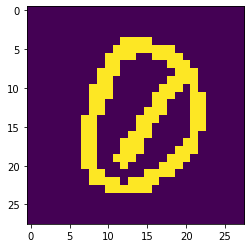

Prediction: 2
Actual: 0


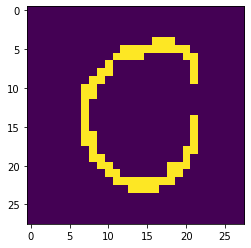

Prediction: 5
Actual: 0


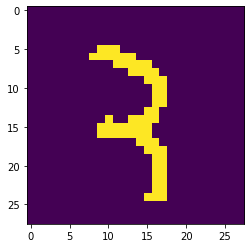

Prediction: 9
Actual: 3


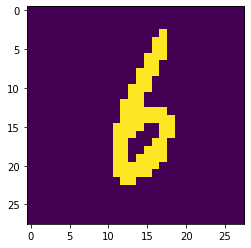

Prediction: 1
Actual: 6


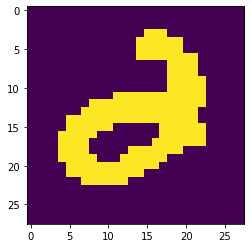

Prediction: 0
Actual: 2


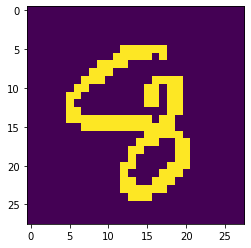

Prediction: 4
Actual: 8


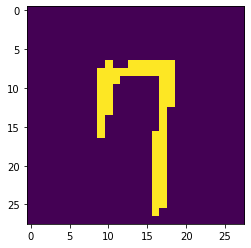

Prediction: 9
Actual: 7


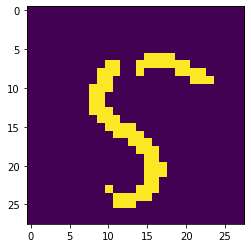

Prediction: 9
Actual: 5


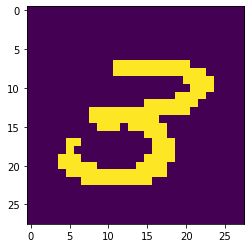

Prediction: 5
Actual: 3


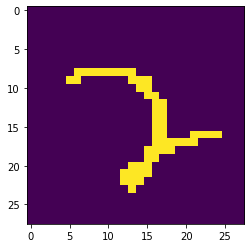

Prediction: 7
Actual: 2


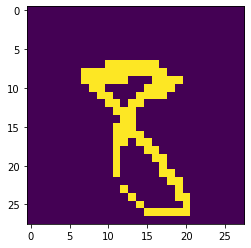

Prediction: 9
Actual: 8


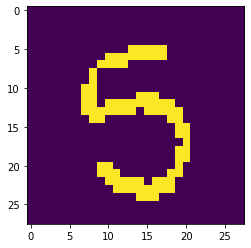

Prediction: 3
Actual: 5


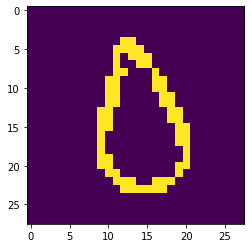

Prediction: 5
Actual: 0


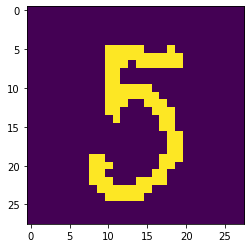

Prediction: 3
Actual: 5


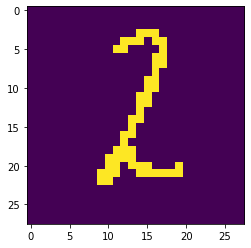

Prediction: 1
Actual: 2


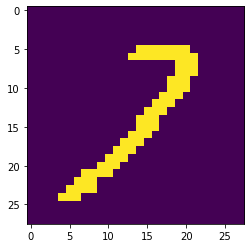

Prediction: 2
Actual: 7


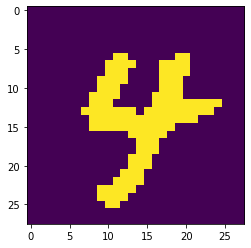

Prediction: 9
Actual: 4


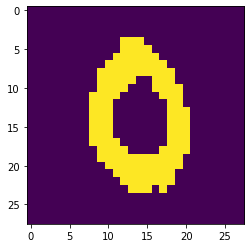

Prediction: 6
Actual: 0


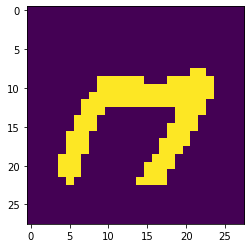

Prediction: 0
Actual: 7


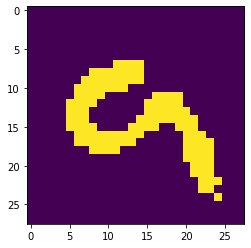

Prediction: 4
Actual: 9


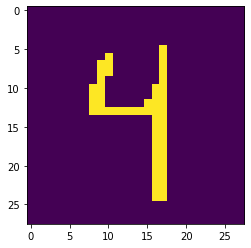

Prediction: 9
Actual: 4


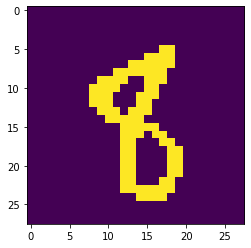

Prediction: 9
Actual: 8


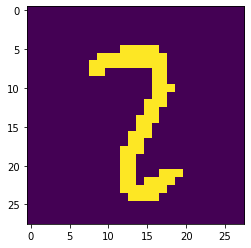

Prediction: 8
Actual: 2


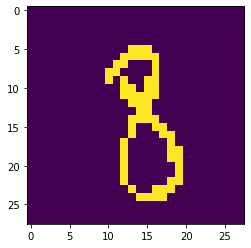

Prediction: 3
Actual: 8


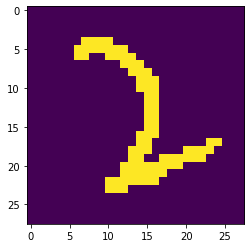

Prediction: 3
Actual: 2


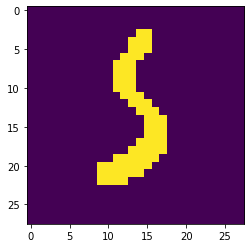

Prediction: 6
Actual: 5


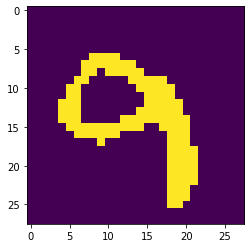

Prediction: 4
Actual: 9


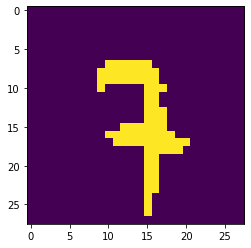

Prediction: 9
Actual: 7


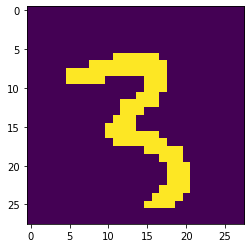

Prediction: 9
Actual: 3


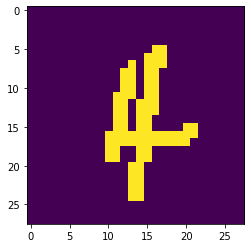

Prediction: 8
Actual: 4


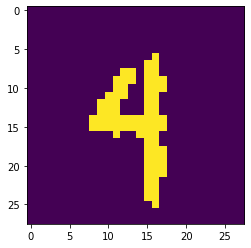

Prediction: 9
Actual: 4


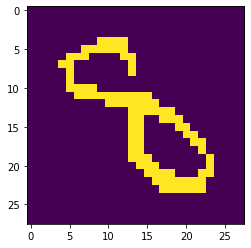

Prediction: 3
Actual: 8


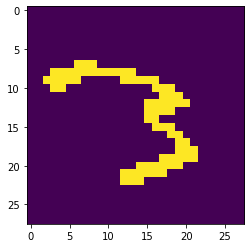

Prediction: 7
Actual: 3


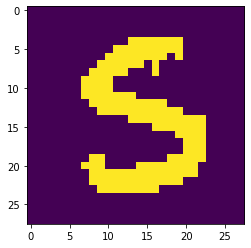

Prediction: 3
Actual: 5


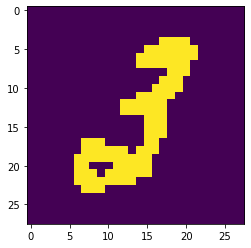

Prediction: 2
Actual: 3


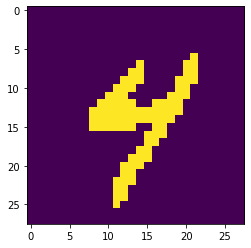

Prediction: 9
Actual: 4


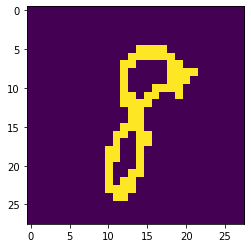

Prediction: 1
Actual: 8


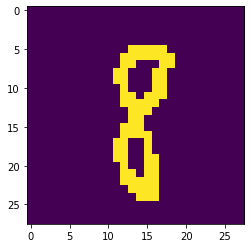

Prediction: 1
Actual: 8


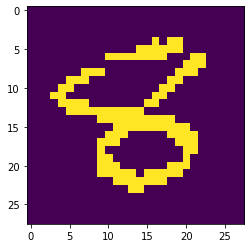

Prediction: 3
Actual: 8


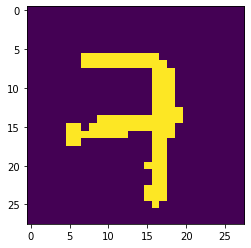

Prediction: 4
Actual: 7


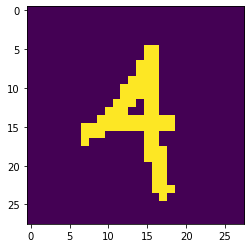

Prediction: 9
Actual: 4


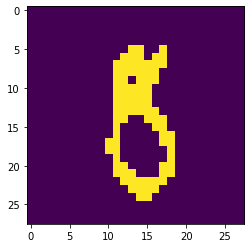

Prediction: 5
Actual: 8


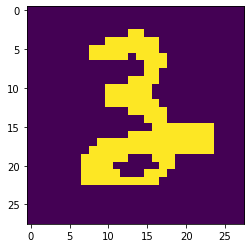

Prediction: 2
Actual: 3


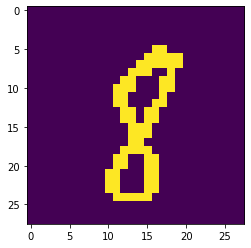

Prediction: 1
Actual: 8


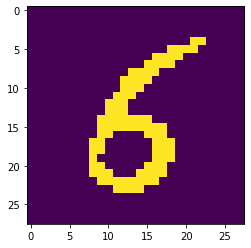

Prediction: 5
Actual: 6


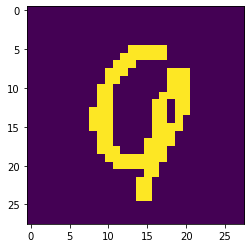

Prediction: 4
Actual: 9


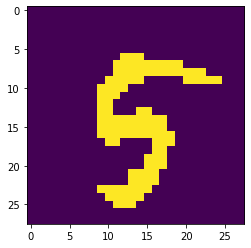

Prediction: 9
Actual: 5


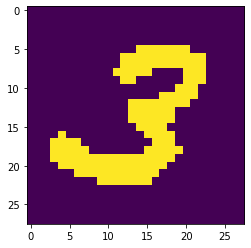

Prediction: 2
Actual: 3


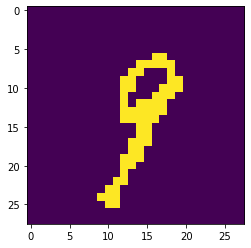

Prediction: 1
Actual: 9


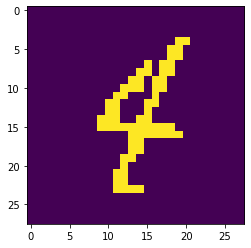

Prediction: 5
Actual: 4


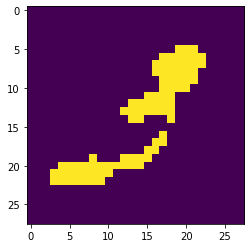

Prediction: 2
Actual: 3


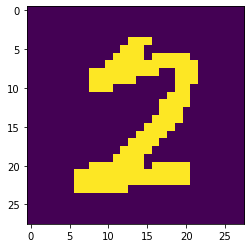

Prediction: 8
Actual: 2


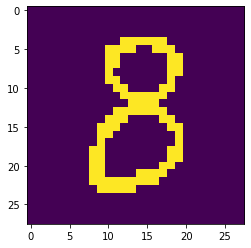

Prediction: 3
Actual: 8


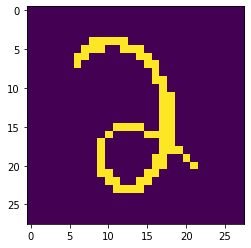

Prediction: 3
Actual: 2


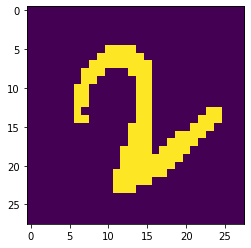

Prediction: 6
Actual: 2


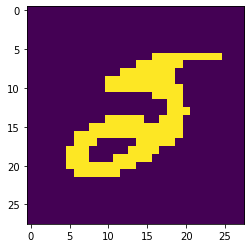

Prediction: 2
Actual: 5


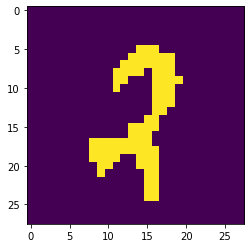

Prediction: 8
Actual: 2


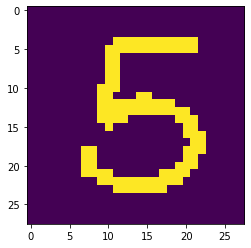

Prediction: 3
Actual: 5


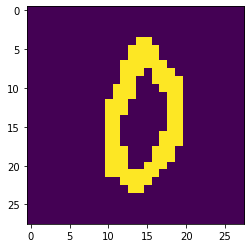

Prediction: 6
Actual: 0


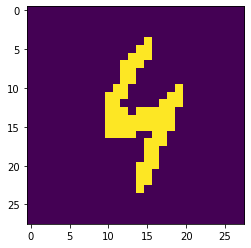

Prediction: 9
Actual: 4


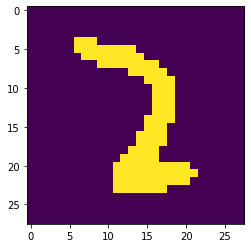

Prediction: 3
Actual: 2


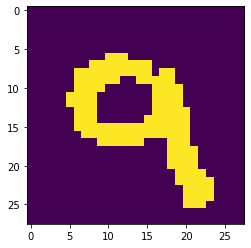

Prediction: 4
Actual: 9


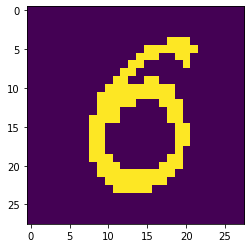

Prediction: 5
Actual: 6


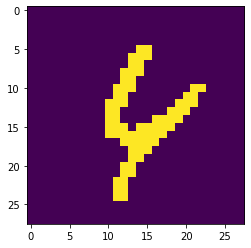

Prediction: 9
Actual: 4


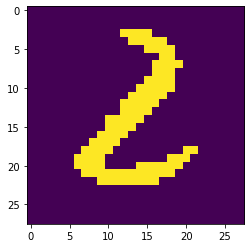

Prediction: 3
Actual: 2


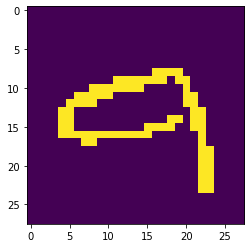

Prediction: 4
Actual: 9


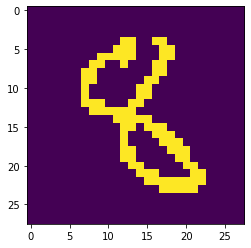

Prediction: 5
Actual: 8


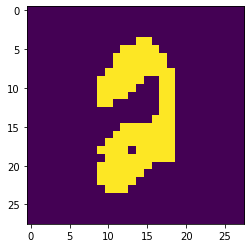

Prediction: 8
Actual: 2


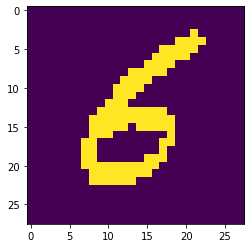

Prediction: 5
Actual: 6


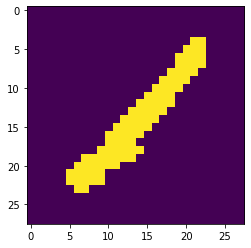

Prediction: 2
Actual: 1


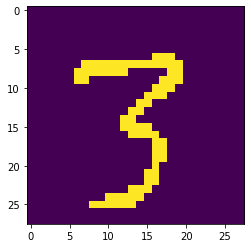

Prediction: 7
Actual: 3


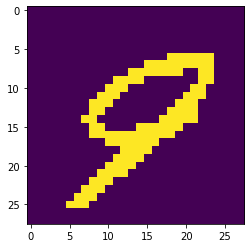

Prediction: 4
Actual: 9


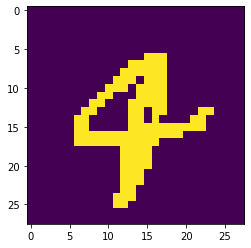

Prediction: 9
Actual: 4


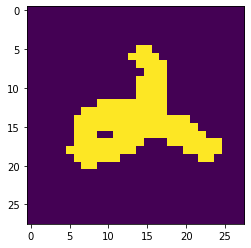

Prediction: 6
Actual: 2


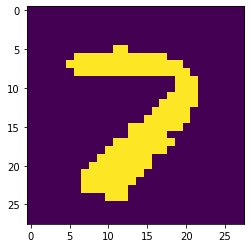

Prediction: 2
Actual: 7


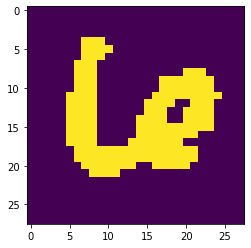

Prediction: 2
Actual: 6


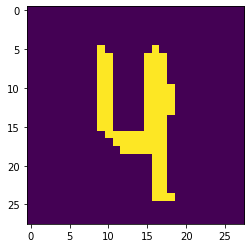

Prediction: 9
Actual: 4


In [16]:
missedX = Xtrain[ytrain != ytrain_hat]
missedy = ytrain[ytrain != ytrain_hat]
missedy_hat = ytrain_hat[ytrain != ytrain_hat]




def show_errors(i):
    plt.imshow(missedX[i].reshape((28,28)))
    plt.show()
    print(f"Prediction: {missedy_hat[i]}")
    print(f"Actual: {missedy[i]}")
    

for i in range(200):
    show_errors(i)